# PHYS 434 Lab 4: Working with "real" data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from scipy import stats
import h5py

from scipy.stats import poisson
from scipy.stats import norm
from scipy.stats import expon

import lmfit
from scipy.optimize import curve_fit
from lmfit import Model, Parameter, report_fit

#this sets the size of the plot to something useful
# plt.rcParams["figure.figsize"] = (20,15)

In [2]:
# import the file for Problem 1
hf = h5py.File('gammaray_lab4.h5', 'r')

# import the file for Problem 2
hp2 = h5py.File('images.h5', 'r')

In [3]:
hf.keys()

<KeysViewHDF5 ['data']>

In [4]:
# import the data into an array variable using the get method
data = np.array(hf.get('data'))

Data should have a time (in gps seconds), Solar phase (deg), Earth longitude (deg), and gamma-ray counts, and more than 25 million data records.

In [5]:
# print out the first row
print(data[:,0])
print(data)

[9.40680016e+08 3.15000000e+02 4.50000000e+01 1.00000000e+01]
[[9.40680016e+08 9.40680016e+08 9.40680016e+08 ... 9.43272016e+08
  9.43272016e+08 9.43272016e+08]
 [3.15000000e+02 3.15007112e+02 3.15014225e+02 ... 3.45319109e+02
  3.45326221e+02 3.45333333e+02]
 [4.50000000e+01 4.50066667e+01 4.50133333e+01 ... 4.49866667e+01
  4.49933333e+01 4.50000000e+01]
 [1.00000000e+01 8.00000000e+00 7.00000000e+00 ... 8.00000000e+00
  1.10000000e+01 1.20000000e+01]]


In [6]:
time = data[0,:]
solarPhase = data[1,:]
earthLongitude = data[2,:]
gammarayCounts = data[3,:]
print(time)
print(time.size)

[9.40680016e+08 9.40680016e+08 9.40680016e+08 ... 9.43272016e+08
 9.43272016e+08 9.43272016e+08]
25920001


In [7]:
# close the file
hf.close()

## Problem 1
### In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

### 1) Download the data from the course website (gammaray_lab4.h5), and import it into your working environment. The data has 4 columns and more than 25 million rows. The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. Make a few plots, generally exploring your data and making sure you understand it. Give a high level description of the data features you see. Specifically comment on whether you see signal contamination in your data, and how you plan to build a background pdf().

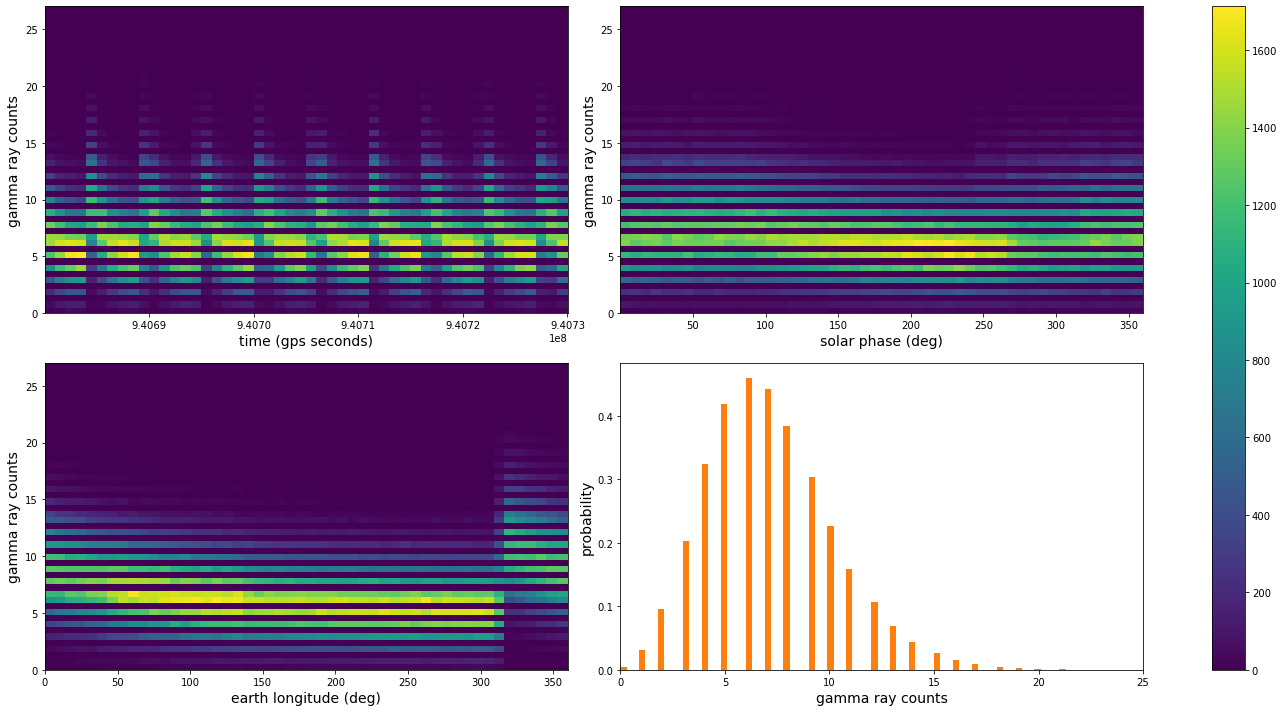

In [8]:
# create a figure with 4 subplots
fig, ax = plt.subplots(2, 2, figsize= (20, 10))

start = 0
end = 500000

# plot solar phase vs time
h = ax[0,0].hist2d(time[start:end], gammarayCounts[start:end], bins = 50);
h = ax[0,1].hist2d(solarPhase[start:end], gammarayCounts[start:end], bins = 50);
h = ax[1,0].hist2d(earthLongitude[start:end], gammarayCounts[start:end], bins = 50);

# x y label
ax[0,0].set_xlabel("time (gps seconds)", fontsize = 14)
ax[0,0].set_ylabel("gamma ray counts",fontsize = 14)
ax[0,1].set_xlabel("solar phase (deg)", fontsize = 14)
ax[0,1].set_ylabel("gamma ray counts", fontsize = 14)
ax[1,0].set_xlabel("earth longitude (deg)", fontsize = 14)
ax[1,0].set_ylabel("gamma ray counts", fontsize = 14)

plt.tight_layout() # minimize the overlap between 2 subplots
plt.colorbar(h[3], ax=ax);

ax[1,1].hist(gammarayCounts, bins = 100, density = True);
ax[1,1].hist(gammarayCounts, bins = 100, density = True);
ax[1,1].set_xlim([0,25]);
ax[1,1].set_xlabel("gamma ray counts", fontsize = 14);
ax[1,1].set_ylabel("probability", fontsize = 14);


In the cell above, I only plotted the first 500000 data points from the dataset to help us see the pattern better. 500000 is a sufficient amount of data points for us to see the pattern clearly, but also it is not too many data point which takes forever to plot and also makes the pattern fades away. <br>
The top left plot of gamma ray counts vs. time and the bottom left plot of gamma ray counts vs. earth longitude are interesting. First, in the gamma ray counts vs. earth longitude plot, we can see the brighter line first decays, and then towards the end of the plotted region there is a sudden glitch in the brighter green part. And looking at this plot along with the gamma ray counts vs. time plot, we can see that the gamma ray counts vs. time plot is essentially many many gamma ray counts vs. earth longitude plots combined. The gamma ray counts vs. time plot shows the same pattern gamma ray counts vs. earth longitude plot has within approximately the time period of 90 minutes (5400 seconds) which is 1 orbit. <br>
This makes sense because the satellite is going around the earth, it comes back to the same place every 360 deg in earth longtidue and every 90 minutes. Therefore, in the gamma ray counts vs. time plot, as time passes by, the satellite comes back to the same degree of earth longitude over and over again, and resemble the same bahavior in the pattern gamma ray counts vs. earth longitude plot every time it comes back to the same degree of earth longitude.<br>

From looking at the plots above, we can also see that the gamma ray counts are discrete, it only takes on integer values. This is telling us the background pdf() should also be a non-continuous distribution. Based on the physical meaning of how the data is taken, I suspect the background pdf() follows the behavior of a Poisson distribution. In the next cell, I will plot the gamma ray counts data and the Poisson distribution in the same plot to compare and check if my guess is correct.

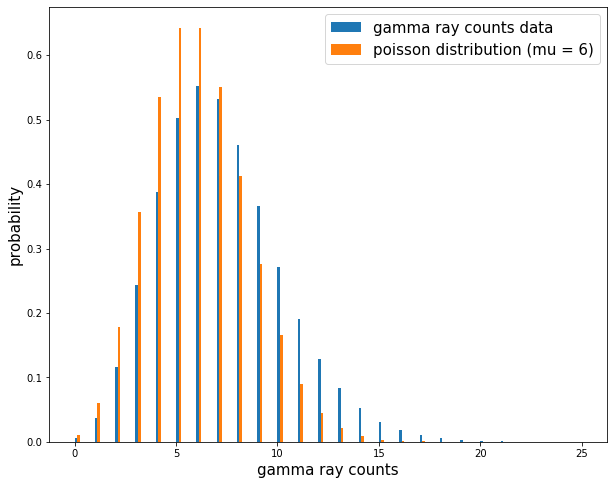

In [9]:
# plot gamma ray background on the same axes with poisson
fig, ax = plt.subplots(1,1,figsize= (10, 8))


# create a random poisson distribution
poi = poisson.rvs(mu = 6, size = gammarayCounts.size);
plt.hist([gammarayCounts,poi], bins = 100, range = [0,25], density = True, rwidth = 10);
plt.xlabel("gamma ray counts", fontsize = 15);
plt.ylabel("probability", fontsize = 15);
plt.legend(["gamma ray counts data", "poisson distribution (mu = 6)"], fontsize = 15);


In the plot above, we can see the general trend of our gamma ray data does follow a Poisson distribution, our guess from earlier is correct. However, if we look into the details, our data doesn't fit the Poisson distribution too well. Therefore, there must be some signal contamination in our data. <br>
From the 2D histograms we can see the mean decays as time progresses within each period, the decay pattern looks like an exponential. Also, within each time bin, the gamma ray counts distribution follows a Poisson. <br>
Therefore, to find the background pdf(), I will first take one full period from the gamma ray counts vs. time plot, put 1 period into multiple time bins, find the mean gamma ray counts in each bin, try to fit the gamma ray counts distribution in each bin with a Poisson, and collect the mean from each bin. After getting all the means, plot them and try to fit them with an exponential decay pdf(). And that will be our background pdf() for 1 full period.

### 2) The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes.

The background varies mostly with longitude and time. The earth longitude starts from 0 and then keep increasing as the satellite moves around the earth. As the degree of earth longitude increases from 0 to 360, the mean value of gamma ray counts decreases which follows an exponential decay. Every 360 degree of earth longitude, the satellite comes back to the same degree it started with. Every 100 milliseconds we get a gamma ray counts distribution that follows the poisson model. Within each time period, which is roughly 5400 seconds, the mean of the poisson decays as an exponential. 

### 3) Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?

The background distribution is basically a Poisson distribution with its mean decay as exponential within each time period (90 minutes).<br>
In the following cells, I will plot the model and compare it to our data.

In [10]:
# break down the time array into bins each with 90 mins(5400s) for a complete period
time_2 = np.arange(time[0], time[time.size-1], 5400)
numberOfPeriods = time_2.size
print("Our data set has " + str(numberOfPeriods) + " periods")

## plot the gamma ray count distribution for the first period
## divide the first two periods into multiple bins, then fit each bin with poission and keep track of the mean value
# create an empty array to store the mean
mean = np.empty(0)

# initialize variables used in for loop
t_start = time[0]
t_end = time[0] + 10800

end = 0
# try to find the index correspond to the first period
for i in range(time.size):
    if time[i] > t_end:
        end = i-1 # index for the right end of the first period
        break
# print(end)
# print(time[end] - time[0])

Our data set has 480 periods


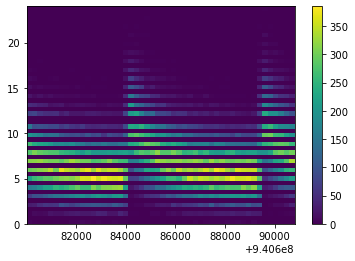

In [11]:
# plot solar phase vs time
plt.hist2d(time[0:end], gammarayCounts[0:end], bins = 50);
plt.colorbar();

Now we are going to use this part of the data, divide it into some number of bins, identify the distribution of gamma-ray counts within each bin, find it's mean value depending on the type of distribution (we suspect it would be a poisson distribution based on the physical meaning of the measurements), collect the mean value for each bin, plot the mean values, and figure out its time dependency. <br>
The color bar in the 2D histogram represents the number of events; the brighter the color on one pixel, the more events there are on that pixel. From the gamma-ray counts vs. time plots above, we can see that the mean gamma-ray counts decay within each period. Therefore, we suspect the time dependence of the mean of poisson distribution follows exponential decay. To check this, I will perform the procedures described above and plot out how the mean changes with time. 

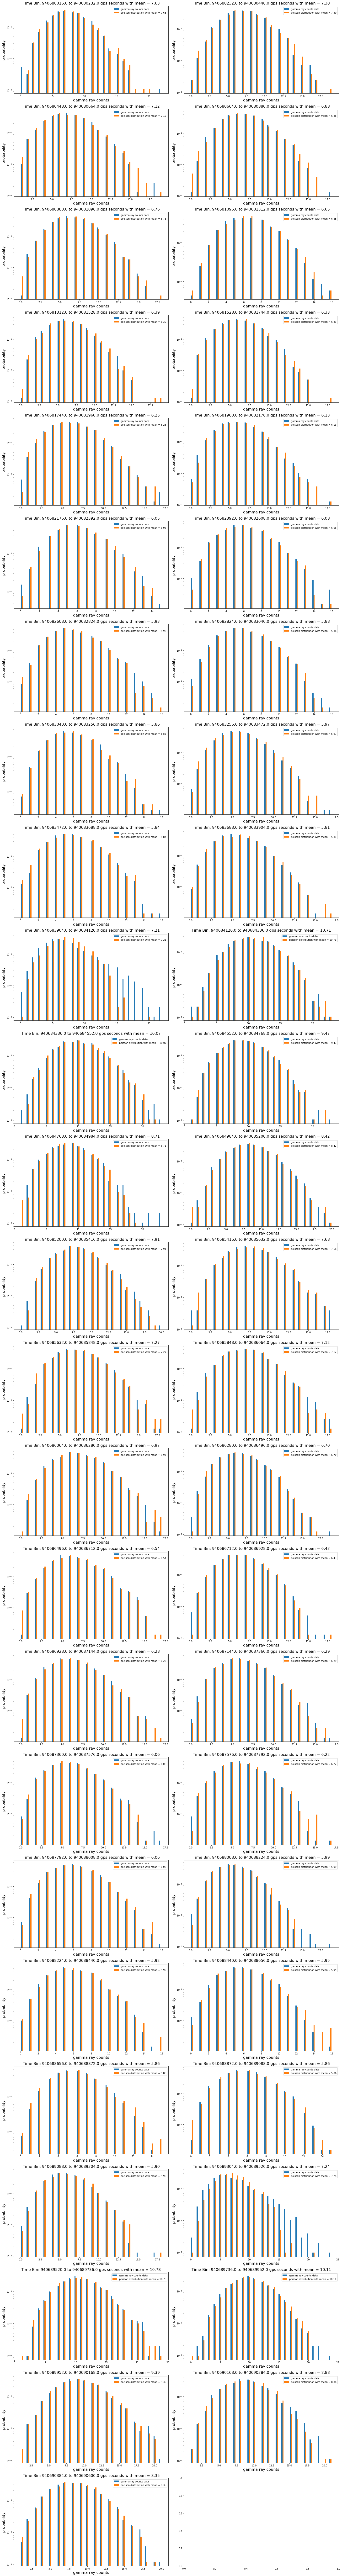

In [12]:
# define the sub data we are using for this part
sub_time = time[0:end]
sub_gammarayCounts = gammarayCounts[0:end]

# define how many bins I want to divide the region above
binCounts = 50
binSize = int(sub_time.size / binCounts)

## divide the data into bins and plot the distribution in each bin out
# create subplots
fig, ax = plt.subplots(25, 2, figsize=(20, 150))
row = 0
col = 0

# create empty mean array to store mean for each bin
mean = np.empty(0)

# fill data into each plot
for i in range(binCounts-1): # the distribution in each bin fills a subplot
    # get time and gammarayCounts(x) for each bin
    timeLeft = sub_time[i*binSize]
    timeRight = sub_time[(i+1)*binSize]
    x = sub_gammarayCounts[i*binSize : (i+1)*binSize]
    
    # create a poisson distribution
    meanInBin = np.mean(sub_gammarayCounts[i*binSize : (i+1)*binSize])
    poissonPerBin = poisson.rvs(mu = meanInBin, size = x.size)
    
    # append meanInBin to mean array
    mean = np.append(mean, meanInBin)
    
    # fill subplot
    ax[row,col].hist([x,poissonPerBin], bins = 50, density = True)
    ax[row,col].set_title("Time Bin: " + str(timeLeft) + " to " + str(timeRight) + " gps seconds with mean = %.2f" %meanInBin, fontsize = 16)
    ax[row,col].set_xlabel("gamma ray counts", fontsize = 16)
    ax[row,col].set_ylabel("probability", fontsize = 16)
    ax[row,col].legend(["gamma ray counts data", "poisson distribution with mean = %.2f" %meanInBin])
    ax[row,col].set_yscale("log")
    
    plt.tight_layout()
    
    # move to the next sub plot
    if (col < 1) : # same row, filling the other columns in the same row
        row = row
        col = col + 1
    else : # this row is full, go to next row, start filling from column 0
        row = row + 1
        col = 0


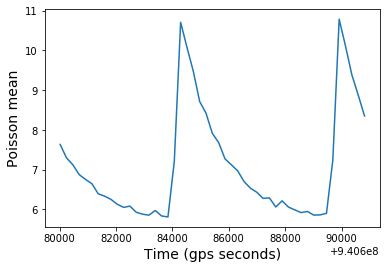

In [13]:
## plot the mean array and find out its time dependence
# create a time array for the x axis in mean plot
x_mean = np.linspace(sub_time[0], sub_time[sub_time.size-1], mean.size)

# plot mean
plt.plot(x_mean, mean);
plt.xlabel("Time (gps seconds)", fontsize = 14);
plt.ylabel("Poisson mean", fontsize = 14);


In [14]:
## extract one full period from this, I chose the one between t = 83000 + 9.406e8 to 90000 + 9.406e8

# find the beginning of the period, about 84000 + 9.406e8 -> that's basically the min mean within first half of the plotted range
period_start = np.min(mean[0 : int(mean.size/2)])
# print(period_start)
# find the index of this min mean in mean array, that's where the period starts
index_start = np.where(mean == period_start)
# print(index_start[0][0]) # check the result see if it's correct
# print(mean.size)
# use the index we got in the last step to find it's corresponding time
time_periodStart = x_mean[index_start[0][0]]
print("Start time of a period: " + str(time_periodStart) + " gps seconds")

# find the beginning of the next period (the start of a new period), about 88000 + 9.406e8 -> that's the min mean within the second half of the plotted range
period_end = np.min(mean[int(mean.size/2) : (mean.size - 1)])
# print(period_end) # print out the result to check
# find the index of this min mean in mean array, that's wehre the period ends
index_end = np.where(mean == period_end)
# print(index_end[0][0])
# use this index to find it's corresponding time value
time_periodEnd = x_mean[index_end[0][0]]
print("End time of a period: " + str(time_periodEnd) + " gps seconds")

print("Time range of this period: " + str(time_periodEnd - time_periodStart) + " gps seconds")

Start time of a period: 940683840.9645833 gps seconds
End time of a period: 940689015.9166666 gps seconds
Time range of this period: 5174.952083349228 gps seconds


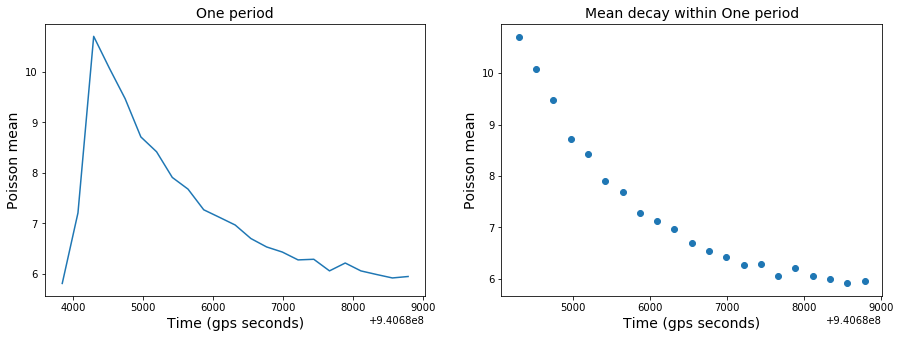

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# plot only the period we found above and try fit the decay part with exp
ax[0].plot(x_mean[index_start[0][0] : index_end[0][0]], mean[index_start[0][0] : index_end[0][0]]);
ax[0].set_xlabel("Time (gps seconds)", fontsize = 14);
ax[0].set_ylabel("Poisson mean", fontsize = 14);
ax[0].set_title("One period", fontsize = 14);

## plot only the mean decay part and try fit with exp
# find the peak
peak = np.max(mean[index_start[0][0] : index_end[0][0]])
# print(peak)
# find the index of the peak
peak_index = np.where(mean == peak)[0][0]
# print(peak_index)
ax[1].scatter(x_mean[peak_index:index_end[0][0]], mean[peak_index:index_end[0][0]]);
ax[1].set_xlabel("Time (gps seconds)", fontsize = 14);
ax[1].set_ylabel("Poisson mean", fontsize = 14);
ax[1].set_title("Mean decay within One period", fontsize = 14);



5.047019996157384 0.16221648770852587 5.723631091513245


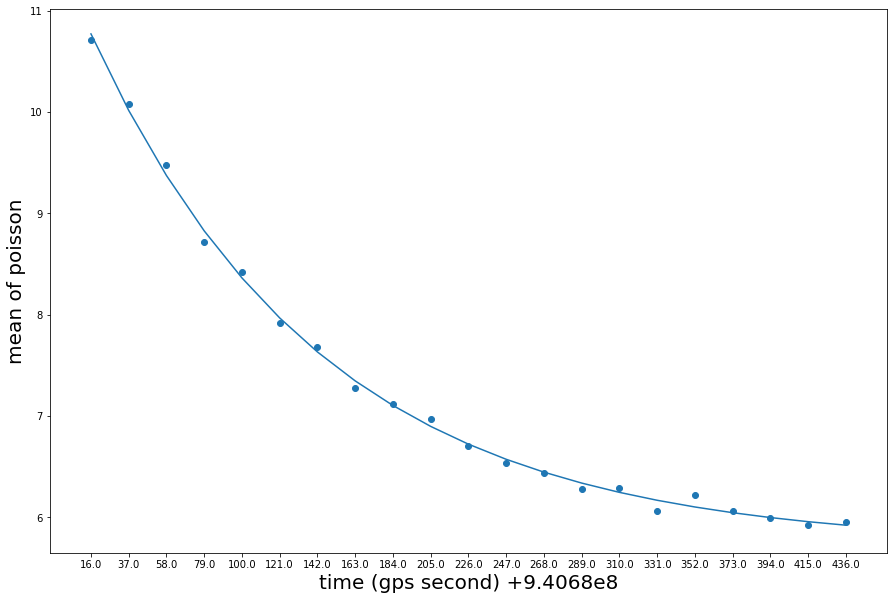

In [16]:
# define exp function
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

x_exp = np.arange(0, mean[peak_index:index_end[0][0]].size, 1)
x_exp_2 = np.arange(0, mean[peak_index:index_end[0][0]].size, 1)
opt, pcov = curve_fit(func, x_exp, mean[peak_index:index_end[0][0]])
a, b, c = opt
y_exp = func(x_exp, a, b, c)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.xticks(x_exp_2, np.arange(x_mean[0], x_mean[x_mean.size-1], x_exp_2.size)-9.4068e8);
plt.plot(x_exp, y_exp);
plt.scatter(x_exp_2, mean[peak_index:index_end[0][0]]);
plt.xlabel("time (gps second) +9.4068e8", fontsize = 20);
plt.ylabel("mean of poisson", fontsize = 20);
print(a, b, c)

From the plot above we can see, our model of exponential function: 5.05*e^(-0.16x)+5.72 fits the mean decay within each time period pretty well. 

### 4) Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?
I will pick 3 different times from the mean decay within one period plot and find the 5-sigma threshold for each of them.

In [17]:
## first find 3 different times randomly
times = np.random.choice(x_mean[peak_index:index_end[0][0]], size = 3)
# print(times)

## find the mean of poisson corresponds to each time
# create an empty array to store all mean of poisson
mean_poisson = np.empty(0)

for i in range(times.size):
    index = np.where(x_mean[peak_index:index_end[0][0]] == times[i])
#     print(index[0][0])
    mean_poisson = np.append(mean_poisson, mean[peak_index:index_end[0][0]][index])
# print(mean_poisson)

## now we've found the mean, we need to calculate 5-sigma for each poisson
# first calculate the probability corresponds to 5-sigma
probability = norm.sf(5)
# create an empty array for signal values corresponds to different mean
signals = np.empty(0)
for i in range(3):
    signals = np.append(signals, poisson.isf(probability, mean_poisson[i]))
print(signals)   

# since our time data is in gps second, the results stored in signals are GRB for 1s
# but the problem asks for 100 millisecond GRB so we need to take the average of the signals to get the signals for 100 milisecond
# 100 milisecond = 0.1 second
signals = signals / 10

# print out the results
for i in range(3):
    print("The 5-sigma threshold for a 100 millisecond GRB at time = " + str(times[i]) + " is " + str(signals[i]))


[23. 22. 30.]
The 5-sigma threshold for a 100 millisecond GRB at time = 940686990.9354167 is 2.3
The 5-sigma threshold for a 100 millisecond GRB at time = 940688565.9208333 is 2.2
The 5-sigma threshold for a 100 millisecond GRB at time = 940684515.9583334 is 3.0


## Problem 2
### In this problem we are going to look at a stack of telescope images (again simulated). We have 10 images, but you and your lab partner will be looking for different signals. One of you will be looking for the faintest stars, while the other will be looking for a transient (something like a super novae that only appears in one image). Flip a coin to determine which of you is pursuing which question.

For this problem, I am looking for transient (super novae). 

### 1) Download the data from images.h5. This is a stack of 10 square images, each 200 pixels on a side.

In [18]:
# check the content in the file
hp2.keys()

<KeysViewHDF5 ['image1', 'imagestack']>

In [19]:
# import the data into an array variable using the get method
image1 = np.array(hp2.get('image1'))
imagestack = np.array(hp2.get('imagestack'))

# print(image1.shape)
# print(imagestack.shape)

# print(imagestack)

In [20]:
# save data of each image to an array
im_1 = imagestack[:,:,0]
im_2 = imagestack[:,:,1]
im_3 = imagestack[:,:,2]
im_4 = imagestack[:,:,3]
im_5 = imagestack[:,:,4]
im_6 = imagestack[:,:,5]
im_7 = imagestack[:,:,6]
im_8 = imagestack[:,:,7]
im_9 = imagestack[:,:,8]
im_10 = imagestack[:,:,9]
# print(im_1.shape)
# print(im_1)
# print(im_2)


### 2) Explore the data. Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf().

In the cell below, I will print out the 10 images I have. Both x and y axes are pixel number, and the color of each pixel box represents the brightness in that region.

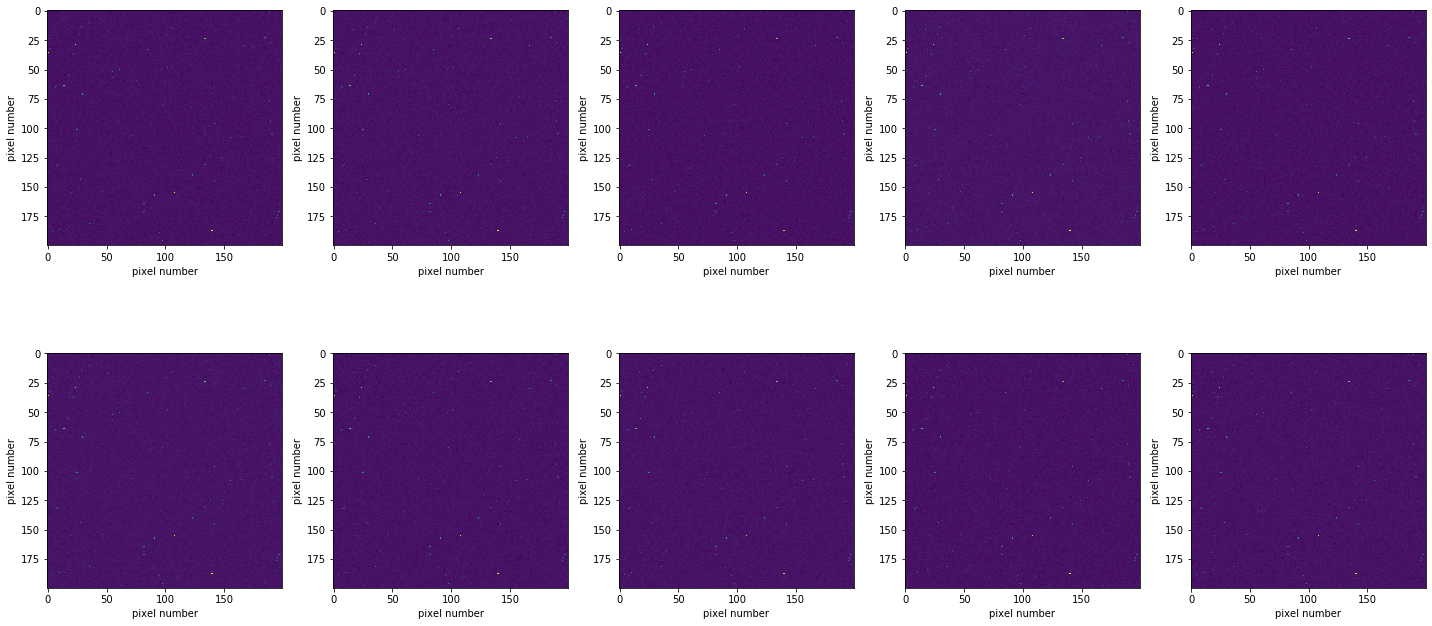

In [21]:
# create a figure with 10 subplots
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
ax[0,0].imshow(im_1);
ax[0,0].set_xlabel("pixel number");
ax[0,0].set_ylabel("pixel number");

ax[0,1].imshow(im_2);
ax[0,1].set_xlabel("pixel number");
ax[0,1].set_ylabel("pixel number");

ax[0,2].imshow(im_3);
ax[0,2].set_xlabel("pixel number");
ax[0,2].set_ylabel("pixel number");

ax[0,3].imshow(im_4);
ax[0,3].set_xlabel("pixel number");
ax[0,3].set_ylabel("pixel number");

ax[0,4].imshow(im_5);
ax[0,4].set_xlabel("pixel number");
ax[0,4].set_ylabel("pixel number");

ax[1,0].imshow(im_6);
ax[1,0].set_xlabel("pixel number");
ax[1,0].set_ylabel("pixel number");

ax[1,1].imshow(im_7);
ax[1,1].set_xlabel("pixel number");
ax[1,1].set_ylabel("pixel number");

ax[1,2].imshow(im_8);
ax[1,2].set_xlabel("pixel number");
ax[1,2].set_ylabel("pixel number");

ax[1,3].imshow(im_9);
ax[1,3].set_xlabel("pixel number");
ax[1,3].set_ylabel("pixel number");

ax[1,4].imshow(im_10);
ax[1,4].set_xlabel("pixel number");
ax[1,4].set_ylabel("pixel number");

plt.tight_layout()

From looking at the images above, we can see that in every image, there are many bright spots. Those are the stars, which are the signal in this distribution. And we can see there is signal contamination in our data.<br>
I am looking for transient in this problem. Transient are like super novae, they are not in the sky permanently, they might appear in one image and not in the others, or might not even appear at all in these 10 images. Also, even though transients are definitely brighter than the background, but they are not necessarily the brightest ones in the image. <br>
Because of these characteristics of transient, we can not use the averaging technique to obtain a background distribution for transient. If we ever average, the transient will just disappear from the distribution.  <br>
Unlike transients, stars are almost always in the sky. Therefore, I decided to take the differences between each of the two consecutive images. The images were taken in sequence, so the time difference between any two consecutive images is shorter than any other kind of pair within those 10 images. For example, the time between when image 1 and image 2 were taken is shorter than the time between when image 1 and image 3 were taken. Taking the differences between images gets rid of the star signals and leaves us a distribution of the background with signals from transient. That would be my background distribution for transient.<br>
Because of the physical meaning of how these measurements were taken, I suspect the background distribution is gaussian. I will first plot the background distributions in the cell below, and if they are indeed gaussian, I will fit them with a gaussian curve.

In [22]:
## calculate the background pdf()

# first take the difference between all 10 images
imDiff_12 = im_1 - im_2
imDiff_23 = im_2 - im_3
imDiff_34 = im_3 - im_4
imDiff_45 = im_4 - im_5
imDiff_56 = im_5 - im_6
imDiff_67 = im_6 - im_7
imDiff_78 = im_7 - im_8
imDiff_89 = im_8 - im_9
imDiff_910 = im_9 - im_10

# put all 9 differences in an array
imDiff = np.array([imDiff_12, imDiff_23, imDiff_34, imDiff_45, imDiff_56, imDiff_67, imDiff_78, imDiff_89, imDiff_910])
# print(imDiff.shape)


In [23]:
# fig, ax = plt.subplots(1,1, figsize=(10, 7))

# # plot avgDiff 
# ax.hist(np.ravel(avgDiff), bins = 500, density = True);

# # create x values for norm.pdf
# x = np.linspace(-2,2,avgDiff.size)
# normpdf = norm.pdf(x, loc = 0, scale = 0.6)

# # plot norm pdf
# ax.plot(x, normpdf)
# ax.set_yscale("log")

[-0.00255676 -0.0005873  -0.00724101  0.00445501 -0.00082362 -0.00372719
  0.0098198  -0.00352371 -0.00139844]
[0.79347444 0.79253797 0.7891124  0.79275177 0.7944891  0.79366126
 0.79437182 0.79259055 0.79092053]


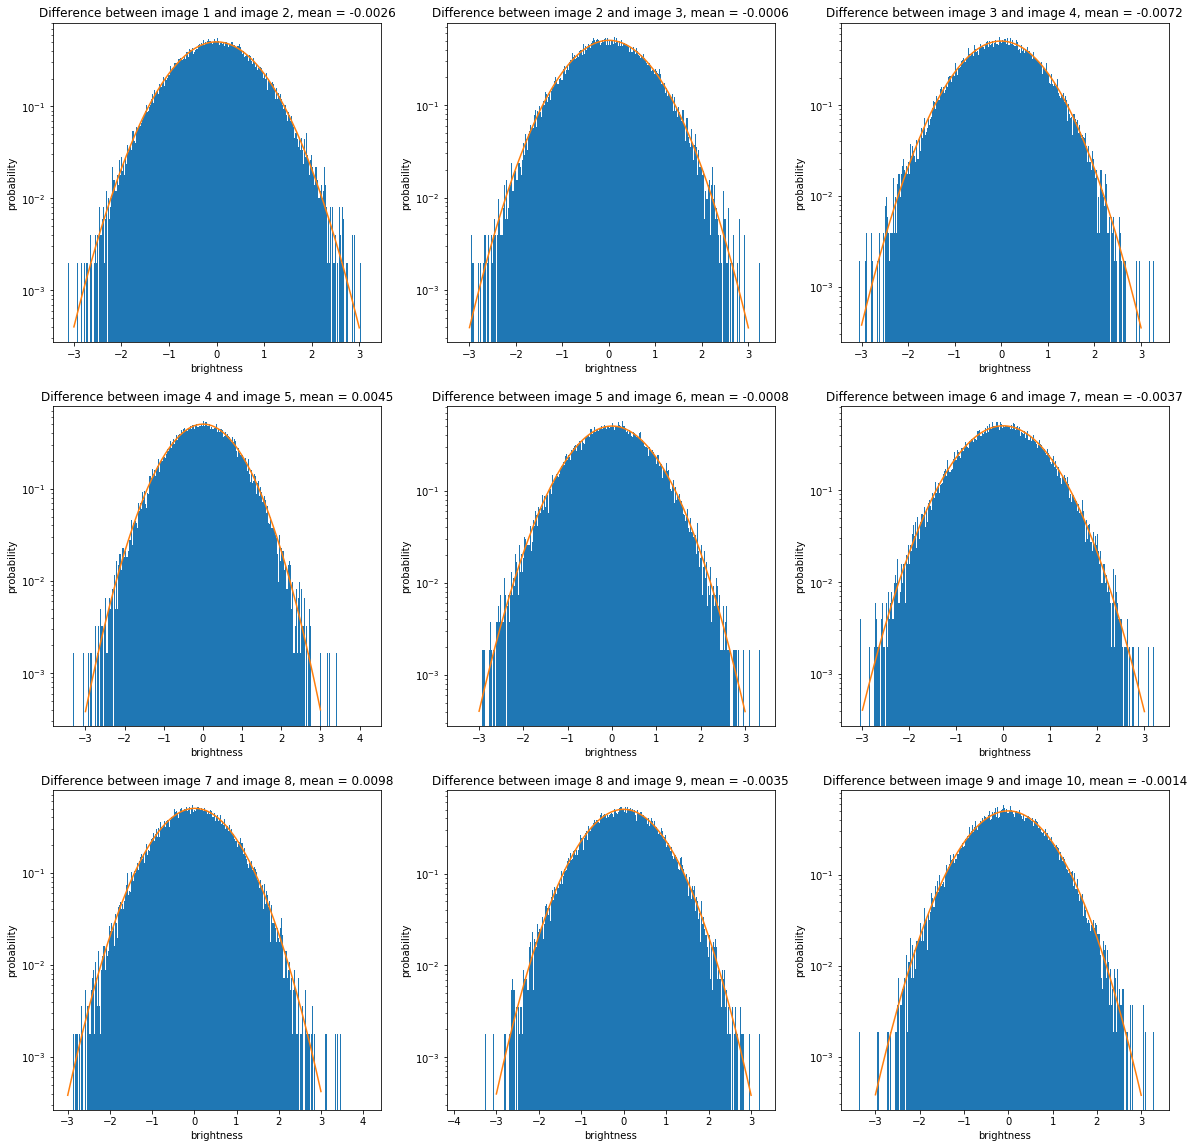

In [24]:
# generate two arrays, mean array and std array to store the mean and std for background gaussian
mean_gaus = np.empty(0)
std_gaus = np.empty(0)

# create a figure with 9 subplots
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
row = 0
col = 0

for i in range(imDiff.shape[0]): # loop through all image difference in imDiff array
    ax[row, col].hist(imDiff[i-1].flatten(), bins = 500, density = True);
    ax[row, col].set_title("Difference between image " + str(i+1) + " and image " + str(i+2) + ", mean = %.4f" %np.mean(imDiff[i-1].flatten()));
    ax[row, col].set_xlabel("brightness");
    ax[row, col].set_ylabel("probability");
    ax[row, col].set_yscale("log");
    
    mean_gaus = np.append(mean_gaus, np.mean(imDiff[i-1].flatten()))
    std_gaus = np.append(std_gaus, np.std(imDiff[i-1].flatten()))

#     print(str(row) + " " + str(col))

    # fit each difference plot with a gaus
    x_gaus = np.linspace(-3, 3, imDiff[i-1].flatten().size)
    ax[row,col].plot(x_gaus, norm.pdf(x_gaus, loc = np.mean(imDiff[i-1].flatten()), scale = np.std(imDiff[i-1].flatten())));
    
    if col < 2: # still on the same row
        row = row
        col = col + 1
    else : # finished a row, go to the next row
        row = row + 1
        col = 0

# check results
print(mean_gaus)
print(std_gaus)
# print(mean_gaus.size)
# print(std_gaus.size)

From the plots of my background distribution above, we can see a gaussian model with mean = 0, standard deviation = 0.8 fits our background distribution pretty well. However, the mean and the variance of the background distribution is always changing from image to image. Since the images were taken at different times, this shows that the background is time dependent. <br>
Since we have 10 images of the same place in the sky, there is no way to know whether the backgound distribution would look different at other places in the sky from only the data we have right now. However, we can compare the location of a few brighter spots and see if they appear to be at the same place. If so, then our data is consistent spatially. <br>
From looking at the images and the plots above, our data is appeared to be spatially consistent.

### 3) Using your background distribution, hunt for your signal (either faint stars, or a transient). Describe what you find.

First I will find where 5-sigma is from the mean in our background distribution, then I will take that value, compare with each image difference, and check if any of the difference between two images has signal greater than the 5-sigma value we found. If there is signal outside 5-sigma, that will most likely to be a transient. 

In [25]:
## find 5 sigma in each background distribution
# first convert 5 sigma to probability
# convert 5 sigma to probability
p = norm.sf(5)
print(p)

# convert probability to signal in each background distribution
# create a fiveSigmaToSignal array to store all values from 9 background dist that corresponds to 5 sigma
fiveSigmaToSignal = np.empty(0)
for i in range(imDiff.shape[0]): # loop through all image difference
    fiveSigmaToSignal = np.append(fiveSigmaToSignal, norm.isf(p, loc = mean_gaus[i], scale = std_gaus[i]))
    print("The brightness corresponds to 5 sigma in background distribution (image difference between image " + str(i+1) + " and image " + str(i+2) + ") is " + str(fiveSigmaToSignal[i]))

2.866515718791933e-07
The brightness corresponds to 5 sigma in background distribution (image difference between image 1 and image 2) is 3.9648154160796825
The brightness corresponds to 5 sigma in background distribution (image difference between image 2 and image 3) is 3.962102556699797
The brightness corresponds to 5 sigma in background distribution (image difference between image 3 and image 4) is 3.938320982083096
The brightness corresponds to 5 sigma in background distribution (image difference between image 4 and image 5) is 3.9682138635052606
The brightness corresponds to 5 sigma in background distribution (image difference between image 5 and image 6) is 3.9716218579711766
The brightness corresponds to 5 sigma in background distribution (image difference between image 6 and image 7) is 3.9645790983723206
The brightness corresponds to 5 sigma in background distribution (image difference between image 7 and image 8) is 3.981678920754713
The brightness corresponds to 5 sigma in ba

In [26]:
# loop through all 9 difference images and try to find if there's any signal beyond 5 sigma
# create an array of boolean to store the result of if anything is beyond 5 sigma
isTransient = np.array([False, False, False, False, False, False, False, False, False])

for i in range(imDiff.shape[0]): # loop through all image difference in imDiff array
    dist = imDiff[i]
    if (abs(dist.min()) > fiveSigmaToSignal[i] or abs(dist.max()) > fiveSigmaToSignal[i]):
        isTransient[i] = True

# print out the result
print(isTransient)

[False False  True False False  True False False False]


From the result printed above, we can see that in two of the background distributions there are signals beyond 5 sigma. One of the distributions is the difference between image 3 and image 4, the other background distribution is the difference between image 6 and image 7. <br>
Those points where it exceed 5-sigma threshold are most likely to be transients. In the next cell, I will find the pixel correspond to the transients. 

In [27]:
# create empty arrays to store row and col number of possible transient
transientRow = np.empty(0)
transientCol = np.empty(0)

##first find the one in imDiff[2]
# print(imDiff[2].shape)
for row in range(200): # looping through
    for col in range(200):
        if imDiff[2][row][col] > fiveSigmaToSignal[2]:
            transientRow = np.append(transientRow, row)
            transientCol = np.append(transientCol, col)
            
## find the one in imDiff[5]
for row in range(200): # looping through
    for col in range(200):
        if imDiff[5][row][col] > fiveSigmaToSignal[5]:
            transientRow = np.append(transientRow, row)
            transientCol = np.append(transientCol, col)
            
print(transientRow)
print(transientCol)


[51.  9.]
[148. 153.]


From the results above, we can see that there was a transient appeared at the location of pixel[51, 148] during the time range when image 3 and 4 were taken, and there was another transient appeared at the location of pixel[9, 153] during the time range when image 6 and image 7 were taken. 

In [28]:
#### this cell is just some random thing that I have tried and did not work
# fig, ax = plt.subplots(1, 2, figsize=(20, 7))
# ## find super nova
# ## assume each image is taken within 1s

# # create x values for norm.pdf
# x = np.linspace(-2,2,avgDiff.size)
# normpdf_1 = norm.pdf(x, loc = 0, scale = 0.6)
# normpdf_2 = norm.pdf(x, loc = 0, scale = 0.6)

# # convolve gaussian for 10 seconds
# timeDuration = 10 # second
# for i in range(0, timeDuration):
#     normpdf_1 = np.convolve(normpdf_1, normpdf_2)
#     normpdf_10s = normpdf_1

# # normalize pdf
# normpdf_10s = normpdf_10s / normpdf_10s.sum()

# ax[0].plot(normpdf_10s);
# # plt.title("PDF of the background for 5 days");
# # plt.xlabel("Number of Gamma-rays Emitted");
# # plt.ylabel("Probability");

# # plot average of convolution
# x_avg = x / 10
# # ax[1].plot(x_avg,normpdf_10s)

# # convolve all differences 

### 4) You and your lab partner had different pdf(), but were using the same data. Explore why this is.

Because we are looking for different things, the background pdf() will also be different. 
To get the pdf() for searching for the faintest stars, we will need to sum all 10 images and then take an average of the sum. This will give us a more refined background distribution with stars, some random noises and transient will disappear after averaging because they don't appear in every image. To find the stars, we will look at the signals beyond 5-sigma in the averaged background distribution. The faintest star will be the signal that's the closest to 5-sigma threshold.<br>
This is also a part of the reason why the background pdf() for the faintest star won't be suitable if we are searching for transient. Any feature of transient will be wiped out from averaging because transients have shorter lifetimes and they won't appear in every image. The background pdf() we use for faintest star won't give us any information about transient and whether they appeared or not. <br>
Depends on our goal and the statistical question being asked, even with the same dataset, the background pdf() needs to be different. 